In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as Layers 
import pandas as pd


2.3.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv')

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6


In [ ]:
time_step = df['Month']
temps = df['Sunspots'].to_numpy()

print(time_step.size)

2820


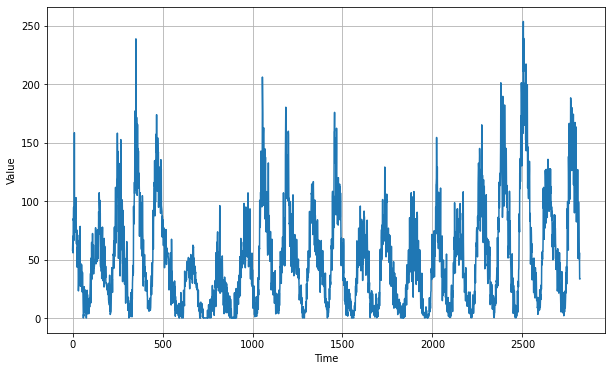

In [ ]:

series = np.array(temps)
time = np.array(range(time_step.size))
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 130
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift = 1,drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[-1:]))
    return ds.batch(batch_size).prefetch(1)
  

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  Layers.Lambda(lambda x: tf.expand_dims(x,axis = -1)),
  Layers.Conv1D(filters = 32, kernel_size= 10, strides = 1, padding = 'causal',activation = 'relu'),
  Layers.LSTM(64,return_sequences=True),
  Layers.LSTM(64,return_sequences=True),
  Layers.Dense(30,activation='relu'),
  Layers.Dense(30,activation='relu'),
  Layers.Dense(1),
  Layers.Lambda(lambda x: x*400.0)

])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 28ms/step - loss: 56.6286 - mae: 57.1262
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 55.4047 - mae: 55.9023
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 53.6879 - mae: 54.1855
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 51.8160 - mae: 52.3134
Epoch 5/100
10/10 [=====

(1e-08, 0.0001, 0.0, 60.0)

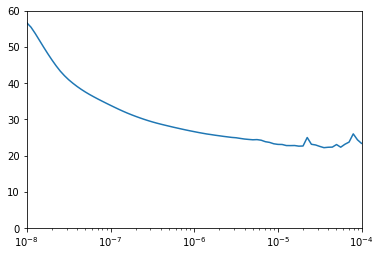

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=256, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  Layers.Lambda(lambda x: tf.expand_dims(x,axis = -1)),
  Layers.Conv1D(filters = 64, kernel_size= 5, strides = 1, padding = 'causal',activation = 'relu'),
  Layers.LSTM(64,return_sequences=True),
  Layers.LSTM(64,return_sequences=True),
  Layers.Dense(30,activation='relu'),
  Layers.Dense(30,activation='relu'),
  Layers.Dense(1),
  Layers.Lambda(lambda x: x*400.0)

])

optimizer = tf.keras.optimizers.SGD(lr= 1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 0s 24ms/step - loss: 44.3911 - mae: 44.8889
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 30.1726 - mae: 30.6691
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 25.8447 - mae: 26.3402
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 24.6461 - mae: 25.1407
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 24.0405 - mae: 24.5351
Epoch 6/100
10/10 [====

In [ ]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

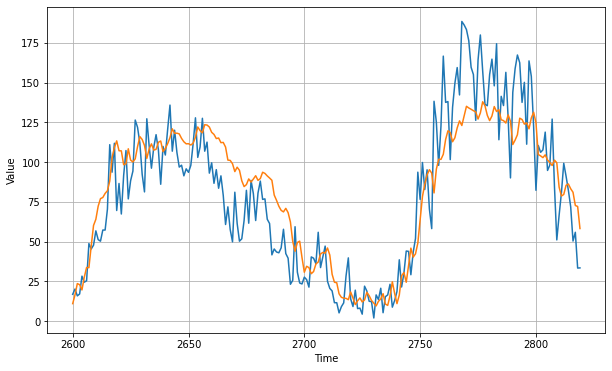

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

18.348255

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 10.919599   16.436483   23.54631    22.840998   19.526443   27.519257
  33.64246    33.555676   47.175953   60.101273   63.961445   72.18625
  76.9654     77.68405    80.23574    81.95129    88.02068   102.633224
 109.08029   113.2924    107.08438   107.01412    98.30208    98.83438
 108.31498   101.21909   100.01181   102.01734   109.67515   115.98318
 114.14621   110.40448   102.26954   108.14264   111.41348   107.4987
 107.96994   112.40819   113.219055  106.53413   108.46034   111.55465
 115.3306    120.87051   118.025734  118.13478   117.691765  114.848946
 112.72365   111.43229   111.521996  110.686615  111.82692   115.63071
 122.02871   119.74004   118.347534  123.45106   123.2583    121.99673
 118.67031   117.34907   114.75459   115.095795  112.17265   112.31365
 109.400116  101.20602   101.00894    98.911026   93.97366    96.73167
  94.79591    88.20188    84.54394    85.80026    89.37405    87.361404
  89.3064     91.38414    88.46533    89.576416   93.55943    92.827705
  